In [3]:
import tensorflow as tf

In [4]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [5]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()
    print(result)
    

42


# Load Data

In [6]:
import pandas as pd
import numpy as np

ecoli = pd.read_csv('C:/Users/terry/Documents/GitHub/Machine_Learning_Portfolio/Datasets/ecoli.csv')
ecoli.drop('accession', axis=1, inplace=True)
ecoli.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


# Data Exploration

In [7]:
ecoli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 8 columns):
mcg      336 non-null float64
gvh      336 non-null float64
lip      336 non-null float64
chg      336 non-null float64
aac      336 non-null float64
alm1     336 non-null float64
alm2     336 non-null float64
class    336 non-null object
dtypes: float64(7), object(1)
memory usage: 21.1+ KB


In [8]:
num_attribs = ['mcg', 'gvh', 'aac', 'alm1', 'alm2']
cat_attribs = ['lip', 'chg']

In [9]:
ecoli[num_attribs].describe()

,mcg,gvh,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.570000,0.710000,0.710000
max,0.890000,1.000000,0.880000,1.000000,0.990000


In [10]:
import matplotlib.pyplot as plt
ecoli[num_attribs].hist(bins=50, figsize=(15,10))
plt.show()

<Figure size 1500x1000 with 6 Axes>

# Generate Train/Test Set

In [11]:
#Stratify on wine type to ensure the distribution is preserved in the train/test set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(ecoli, ecoli['class']):
    strat_train_set = ecoli.loc[train_index]
    strat_test_set = ecoli.loc[test_index]
    
display(ecoli['class'].value_counts() / len(ecoli))
display(strat_test_set['class'].value_counts() / len(strat_test_set))

cp     0.425595
im     0.229167
pp     0.154762
imU    0.104167
om     0.059524
omL    0.014881
imL    0.005952
imS    0.005952
Name: class, dtype: float64

cp     0.426471
im     0.235294
pp     0.161765
imU    0.102941
om     0.058824
omL    0.014706
Name: class, dtype: float64

In [12]:
#Set aside the test set and work with the training set
ecoli = strat_train_set.copy()

# Feature Correlation

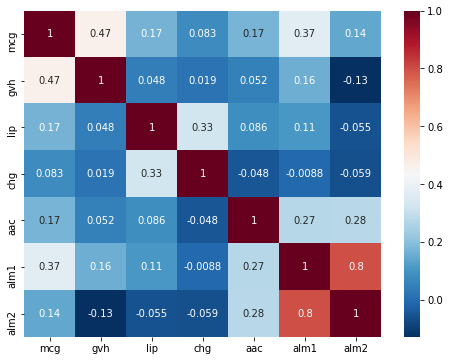

In [13]:
#Correlation Heat Map
import seaborn as sns

corr_matrix = ecoli.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')

# Data Pre-processing Pipeline

In [76]:
#Process the data with a numerical and categorical pipeline
#The numerical pipeline fills missing values and scales the features
#The categorical pipeline encodes categorical features and does feature engineering

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

ecoli_prepared = full_pipeline.fit_transform(ecoli)
y_train = ecoli['class']
pd.DataFrame(ecoli_prepared).head()

C:\Users\terry\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,0,1,2,3,4,5,6,7,8
0,0.722643,0.970527,1.366688,0.797843,1.019380,1.0,0.0,1.0,0.0
1,-0.711544,-0.554410,0.293786,-0.850201,-0.437395,1.0,0.0,1.0,0.0
2,-0.764662,0.042304,0.954033,0.986191,1.165058,1.0,0.0,1.0,0.0
3,-0.339718,-0.885918,0.293786,-0.708940,-0.291717,1.0,0.0,1.0,0.0
4,-0.817780,-1.482632,-0.696586,-0.708940,-0.291717,1.0,0.0,1.0,0.0


In [77]:
y_test = strat_test_set['class']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_le = le.transform(y_train) 
y_test_le = le.transform(y_test)

In [38]:
from sklearn.model_selection import cross_val_score
import tensorflow.contrib.learn as skflow

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=ecoli_prepared.shape[0])]
n_classes = len(y_train_le)
nn_shape = [
    int(n_classes*1.5),
    int(n_classes*2.5),
    int(n_classes*1.5),
]

X_test_prepared = full_pipeline.transform(strat_test_set)

classifier = skflow.DNNClassifier(hidden_units=nn_shape, n_classes=n_classes, feature_columns=feature_columns)
classifier.fit(ecoli_prepared, y_train_le, steps=1000)

pred = list(classifier.predict(X_test_prepared))
score = metrics.accuracy_score(y_test_le, pred)
print("Accuracy: %f" % score)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000227ED55B4A8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\terry\\AppData\\Local\\Temp\\tmp2mmwf0uv'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving che

In [71]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [72]:
from functools import partial

reset_graph()

batch_norm_momentum = 0.9
n_inputs = 9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [73]:
n_epochs = 20
batch_size = 200

In [80]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
X_valid, X_train = ecoli_prepared[:100], ecoli_prepared[100:]
y_valid, y_train = y_train_le[:100], y_train_le[100:]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(ecoli_prepared, y_train_le, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.07
1 Validation accuracy: 0.06
2 Validation accuracy: 0.05
3 Validation accuracy: 0.05
4 Validation accuracy: 0.05
5 Validation accuracy: 0.05
6 Validation accuracy: 0.05
7 Validation accuracy: 0.06
8 Validation accuracy: 0.07
9 Validation accuracy: 0.09
10 Validation accuracy: 0.11
11 Validation accuracy: 0.13
12 Validation accuracy: 0.14
13 Validation accuracy: 0.15
14 Validation accuracy: 0.15
15 Validation accuracy: 0.16
16 Validation accuracy: 0.16
17 Validation accuracy: 0.17
18 Validation accuracy: 0.19
19 Validation accuracy: 0.19


In [75]:
n_inputs

9